# Convert SSD Detection Model to TFLite model #

Use Google's [facessd_mobilenet_v2_quantized_320x320_open_image_v4](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#open-images-trained-models) model and the [models/research/object_detection](https://github.com/tensorflow/models/tree/master/research/object_detection) repo

**Process:**

1. Export tflite graph
2. Convert to int8/float tflite model
3. Inference

**Issue:**

1. [The difference between original tflite graph and the tflite graph exported from the checkpoint](#The-difference-between-original-tflite-graph-and-the-tflite-graph-exported-from-the-checkpoint)
2. [Warning message when exporting uint8 tflite models](#Warning-message-when-exporting-uint8-tflite-models)
3. [Warning message when exporting float tflite models](#Warning-message-when-exporting-float-tflite-models)
4. [The detection_classes outputs are 0(s)](#The-detection_classes-outputs-are-0(s))
5. [What's the suitable threshold value for detection_scores?](#What's-the-suitable-threshold-value-for-detection_scores?)

**Reference:**

- https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_on_mobile_tensorflowlite.md

## Export tflite graph ##

```
python object_detection/export_tflite_ssd_graph.py \
    --pipeline_config_path=$CONFIG_FILE \
    --trained_checkpoint_prefix=$CHECKPOINT_PATH \
    --output_directory=$OUTPUT_DIR/tflite \
    --add_postprocessing_op=true

```

In [1]:
CONFIG_FILE = '/workspace/projects/facessd_mobilenet_v2_quantized_320x320_open_image_v4/pipeline.config'
CHECKPOINT_PATH = '/workspace/projects/facessd_mobilenet_v2_quantized_320x320_open_image_v4/model.ckpt'
OUTPUT_DIR = '/workspace/projects/facessd_mobilenet_v2_quantized_320x320_open_image_v4'

In [2]:
!cd models/research/ && python object_detection/export_tflite_ssd_graph.py \
--pipeline_config_path={CONFIG_FILE} \
--trained_checkpoint_prefix={CHECKPOINT_PATH} \
--output_directory={OUTPUT_DIR}/tflite \
--add_postprocessing_op=true

2018-11-23 10:31:14.627765: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2018-11-23 10:31:14.715205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:964] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-11-23 10:31:14.715595: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.683
pciBusID: 0000:01:00.0
totalMemory: 10.91GiB freeMemory: 9.99GiB
2018-11-23 10:31:14.715610: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2018-11-23 10:31:14.901395: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-11-23 10:31:14.901426: I tensorflow/core/common_runtime/gpu/gpu_device.cc:988]     

In [3]:
!ls {OUTPUT_DIR}/tflite

tflite_graph.pb  tflite_graph.pbtxt


###### The difference between original tflite graph and the tflite graph exported from the checkpoint ######

In [4]:
import os

original_tflite_graph = os.path.join(OUTPUT_DIR, 'tflite_graph.pbtxt')
tflite_graph_exported_from_checkpoint = os.path.join(OUTPUT_DIR, 'tflite', 'tflite_graph.pbtxt')

!diff {original_tflite_graph} {tflite_graph_exported_from_checkpoint}

43991c43991
<       i: 50
---
>       i: 10


original_tflite_graph

- max_detections = 50

![original_tflite_graph](./original_tflite_graph.png)

tflite_graph_exported_from_checkpoint

- max_detections = 10

![tflite_graph_exported_from_checkpoint](./tflite_graph_exported_from_checkpoint.png)

## Convert tflite graph to uint8 tflite model ##

```
bazel run --config=opt tensorflow/contrib/lite/toco:toco -- \
--input_file=$OUTPUT_DIR/tflite_graph.pb \
--output_file=$OUTPUT_DIR/model_quantized.tflite \
--input_shapes=1,320,320,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=QUANTIZED_UINT8 \
--mean_values=128 \
--std_values=128 \
--change_concat_input_ranges=false \
--allow_custom_ops
```

In [5]:
!cd tensorflow/ && bazel run --config=opt tensorflow/contrib/lite/toco:toco -- \
--input_file={OUTPUT_DIR}/tflite_graph.pb \
--output_file={OUTPUT_DIR}/model_quantized.tflite \
--input_shapes=1,320,320,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=QUANTIZED_UINT8 \
--mean_values=128 \
--std_values=128 \
--change_concat_input_ranges=false \
--allow_custom_ops

Loading: 
Loading: 0 packages loaded
Loading: 0 packages loaded
    currently loading: tensorflow/contrib/lite/toco
Analyzing: target //tensorflow/contrib/lite/toco:toco (2 packages loaded)
Analyzing: target //tensorflow/contrib/lite/toco:toco (6 packages loaded)
    currently loading: @bazel_tools//platforms
Analyzing: target //tensorflow/contrib/lite/toco:toco (24 packages loaded)
    currently loading: @protobuf_archive// ... (6 packages)
Analyzing: target //tensorflow/contrib/lite/toco:toco (35 packages loaded)
    currently loading: tensorflow/core/kernels
Analyzing: target //tensorflow/contrib/lite/toco:toco (50 packages loaded)
    currently loading: tensorflow/core/kernels ... (2 packages)
Analyzing: target //tensorflow/contrib/lite/toco:toco (66 packages loaded)
    currently loading: tensorflow/core/kernels
Analyzing: target //tensorflow/contrib/lite/toco:toco (67 packages loaded)
    currently loading: @snappy//
INFO: Analysed target //tensorflow/contrib/lite/toco:toco (69 p

###### Warning message when exporting uint8 tflite models ######

> Converting unsupported operation: TFLite_Detection_PostProcess

> Constant array anchors lacks MinMax information. To make up for that, we will now compute the MinMax from actual array elements. That will result in quantization parameters that probably do not match whichever arithmetic was used during training, and thus will probably be a cause of poor inference accuracy.

> Ignoring unsupported type in list attribute with key '\_output\_types'

In [6]:
!ls {OUTPUT_DIR}/model_quantized.tflite

/workspace/projects/facessd_mobilenet_v2_quantized_320x320_open_image_v4/model_quantized.tflite


## Convert tflite graph to float tflite model ##

```
bazel run --config=opt tensorflow/contrib/lite/toco:toco -- \
--input_file=$OUTPUT_DIR/tflite_graph.pb \
--output_file=$OUTPUT_DIR/model_float.tflite \
--input_shapes=1,320,320,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops
```

In [7]:
!cd tensorflow/ && bazel run --config=opt tensorflow/contrib/lite/toco:toco -- \
--input_file={OUTPUT_DIR}/tflite_graph.pb \
--output_file={OUTPUT_DIR}/model_float.tflite \
--input_shapes=1,320,320,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops

Loading: 
Loading: 0 packages loaded
Loading: 0 packages loaded
    currently loading: tensorflow/contrib/lite/toco
Analyzing: target //tensorflow/contrib/lite/toco:toco (2 packages loaded)
Analyzing: target //tensorflow/contrib/lite/toco:toco (7 packages loaded)
    currently loading: @local_config_sh//
Analyzing: target //tensorflow/contrib/lite/toco:toco (32 packages loaded)
    currently loading: tensorflow/core/kernels ... (4 packages)
Analyzing: target //tensorflow/contrib/lite/toco:toco (35 packages loaded)
    currently loading: tensorflow/core/kernels ... (2 packages)
Analyzing: target //tensorflow/contrib/lite/toco:toco (47 packages loaded)
    currently loading: tensorflow/core/kernels
Analyzing: target //tensorflow/contrib/lite/toco:toco (55 packages loaded)
    currently loading: tensorflow/core/kernels ... (2 packages)
Analyzing: target //tensorflow/contrib/lite/toco:toco (66 packages loaded)
    currently loading: tensorflow/core/kernels
Analyzing: target //tensorflow/co

###### Warning message when exporting float tflite models ######

> Ignoring unsupported type in list attribute with key '\_output\_types'

In [8]:
!ls {OUTPUT_DIR}/model_float.tflite

/workspace/projects/facessd_mobilenet_v2_quantized_320x320_open_image_v4/model_float.tflite


## Inference ##

In [9]:
from tensorflow.contrib.lite.python import interpreter as interpreter_wrapper
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

def get_uint8_img_data(img_path):
  input_data = cv2.imread(img_path)
  input_data = cv2.resize(input_data, (320, 320), interpolation=cv2.INTER_CUBIC)
  input_data = input_data[:,:,::-1] # BGR to RGB

  return input_data

def get_float_img_data(img_path):
  input_data = cv2.imread(img_path)
  input_data = cv2.resize(input_data, (320, 320), interpolation=cv2.INTER_CUBIC)
  input_data = input_data[:,:,::-1] # BGR to RGB
  input_data = np.float32(input_data)

  return input_data

def inference(input_data, model_path, draw_img_path):
  # Load TFLite model and allocate tensors.
  interpreter = interpreter_wrapper.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()

  # Get input and output tensors.
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # Read image
  image_expanded = np.expand_dims(input_data, axis=0)
  draw = cv2.imread(draw_img_path)

  # Inference
  interpreter.set_tensor(input_details[0]['index'], image_expanded)
  interpreter.invoke()

  boxes = interpreter.get_tensor(output_details[0]['index'])
  classes = interpreter.get_tensor(output_details[1]['index'])
  scores = interpreter.get_tensor(output_details[2]['index'])
  num_detections = interpreter.get_tensor(output_details[3]['index'])

  boxes = boxes[0].tolist()
  classes = classes[0].tolist()
  scores = scores[0].tolist()
  num_detections = int(num_detections[0])

  print('num_detections: %d' % num_detections)

  # Display result
  for i in range(num_detections):
    box = boxes[i]
    class_label = int(classes[i])
    score = scores[i]

    x1 = int(box[1] * draw.shape[1])
    x2 = int(box[3] * draw.shape[1])
    y1 = int(box[0] * draw.shape[0])
    y2 = int(box[2] * draw.shape[0])

    cv2.rectangle(draw, (x1, y1), (x2, y2), (255, 0, 0), 5)
    print('class: %d, score: %f, [xmin: %d, xmax: %d, ymin: %d, ymax: %d]' % (class_label, score, x1, x2, y1, y2))
    
  plt.figure()
  plt.imshow(draw[:,:,::-1])

num_detections: 9
class: 0, score: 0.917969, [xmin: 573, xmax: 686, ymin: 136, ymax: 234]
class: 0, score: 0.832031, [xmin: 437, xmax: 553, ymin: 125, ymax: 226]
class: 0, score: 0.832031, [xmin: 132, xmax: 243, ymin: 215, ymax: 312]
class: 0, score: 0.500000, [xmin: 689, xmax: 820, ymin: 200, ymax: 314]
class: 0, score: 0.007812, [xmin: 639, xmax: 739, ymin: 166, ymax: 256]
class: 0, score: 0.007812, [xmin: 0, xmax: 18, ymin: 190, ymax: 303]
class: 0, score: 0.003906, [xmin: 462, xmax: 595, ymin: 117, ymax: 236]
class: 0, score: 0.003906, [xmin: 588, xmax: 773, ymin: 146, ymax: 279]
class: 0, score: 0.003906, [xmin: 2, xmax: 24, ymin: 165, ymax: 287]


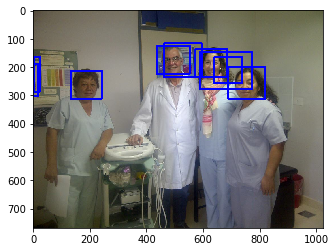

In [10]:
# uint8 model inference
img_path = './open-images-dataset/000132c20b84269b.jpg'
model_path = os.path.join(OUTPUT_DIR, 'model_quantized.tflite')
input_data = get_uint8_img_data(img_path)
inference(input_data, model_path, img_path)

num_detections: 50
class: 0, score: 0.000340, [xmin: 695, xmax: 809, ymin: 208, ymax: 314]
class: 0, score: 0.000190, [xmin: 0, xmax: 543, ymin: -6, ymax: 123]
class: 0, score: 0.000153, [xmin: -3, xmax: 192, ymin: -1, ymax: 13]
class: 0, score: 0.000153, [xmin: 3, xmax: 19, ymin: 175, ymax: 366]
class: 0, score: 0.000153, [xmin: 1, xmax: 27, ymin: 664, ymax: 771]
class: 0, score: 0.000153, [xmin: 1005, xmax: 1022, ymin: -14, ymax: 176]
class: 0, score: 0.000153, [xmin: -1, xmax: 14, ymin: -3, ymax: 146]
class: 0, score: 0.000153, [xmin: 26, xmax: 503, ymin: 3, ymax: 35]
class: 0, score: 0.000153, [xmin: 4, xmax: 15, ymin: 362, ymax: 570]
class: 0, score: 0.000153, [xmin: 3, xmax: 14, ymin: 437, ymax: 632]
class: 0, score: 0.000153, [xmin: 4, xmax: 46, ymin: 117, ymax: 467]
class: 0, score: 0.000153, [xmin: 2, xmax: 46, ymin: 320, ymax: 677]
class: 0, score: 0.000153, [xmin: 0, xmax: 30, ymin: 1, ymax: 38]
class: 0, score: 0.000153, [xmin: 976, xmax: 1022, ymin: -16, ymax: 356]
class: 

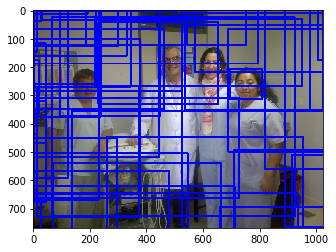

In [11]:
# float model inference
img_path = './open-images-dataset/000132c20b84269b.jpg'
model_path = os.path.join(OUTPUT_DIR, 'model_float.tflite')
input_data = get_float_img_data(img_path)
inference(input_data, model_path, img_path)

num_detections: 1
class: 0, score: 0.003906, [xmin: 601, xmax: 714, ymin: 309, ymax: 437]


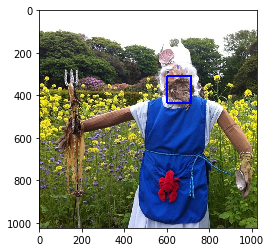

In [12]:
# uint8 model inference
img_path = './open-images-dataset/0002ab0af02e4a77.jpg'
model_path = os.path.join(OUTPUT_DIR, 'model_quantized.tflite')
input_data = get_uint8_img_data(img_path)
inference(input_data, model_path, img_path)

num_detections: 50
class: 0, score: 0.000129, [xmin: 41, xmax: 987, ymin: 551, ymax: 1025]
class: 0, score: 0.000096, [xmin: 357, xmax: 1021, ymin: 325, ymax: 1027]
class: 0, score: 0.000090, [xmin: 4, xmax: 388, ymin: 52, ymax: 989]
class: 0, score: 0.000087, [xmin: 899, xmax: 1022, ymin: 83, ymax: 972]
class: 0, score: 0.000087, [xmin: 740, xmax: 1017, ymin: 133, ymax: 953]
class: 0, score: 0.000080, [xmin: 889, xmax: 1461, ymin: -128, ymax: 1019]
class: 0, score: 0.000080, [xmin: -28, xmax: 507, ymin: 628, ymax: 1411]
class: 0, score: 0.000080, [xmin: 16, xmax: 858, ymin: 1, ymax: 401]
class: 0, score: 0.000072, [xmin: 663, xmax: 1876, ymin: 924, ymax: 1483]
class: 0, score: 0.000072, [xmin: 260, xmax: 758, ymin: 584, ymax: 1096]
class: 0, score: 0.000072, [xmin: 72, xmax: 986, ymin: 313, ymax: 707]
class: 0, score: 0.000072, [xmin: 482, xmax: 954, ymin: 555, ymax: 1089]
class: 0, score: 0.000072, [xmin: 381, xmax: 1023, ymin: 10, ymax: 833]
class: 0, score: 0.000071, [xmin: -161, x

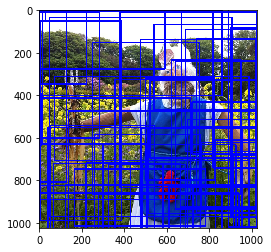

In [13]:
# float model inference
img_path = './open-images-dataset/0002ab0af02e4a77.jpg'
model_path = os.path.join(OUTPUT_DIR, 'model_float.tflite')
input_data = get_float_img_data(img_path)
inference(input_data, model_path, img_path)

num_detections: 2
class: 0, score: 0.003906, [xmin: 230, xmax: 512, ymin: 190, ymax: 591]
class: 0, score: 0.003906, [xmin: 111, xmax: 634, ymin: 29, ymax: 718]


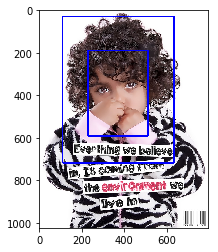

In [14]:
# uint8 model inference
img_path = './open-images-dataset/000dbcc283d87f67.jpg'
model_path = os.path.join(OUTPUT_DIR, 'model_quantized.tflite')
input_data = get_uint8_img_data(img_path)
inference(input_data, model_path, img_path)

num_detections: 50
class: 0, score: 0.000072, [xmin: 6, xmax: 190, ymin: -10, ymax: 898]
class: 0, score: 0.000069, [xmin: 4, xmax: 25, ymin: 3, ymax: 43]
class: 0, score: 0.000069, [xmin: 0, xmax: 9, ymin: -6, ymax: 211]
class: 0, score: 0.000069, [xmin: 787, xmax: 796, ymin: 372, ymax: 662]
class: 0, score: 0.000069, [xmin: 0, xmax: 8, ymin: 136, ymax: 374]
class: 0, score: 0.000069, [xmin: 790, xmax: 798, ymin: 263, ymax: 566]
class: 0, score: 0.000069, [xmin: 4, xmax: 21, ymin: 879, ymax: 1030]
class: 0, score: 0.000069, [xmin: 4, xmax: 39, ymin: 984, ymax: 1028]
class: 0, score: 0.000069, [xmin: 769, xmax: 797, ymin: 2, ymax: 57]
class: 0, score: 0.000069, [xmin: 0, xmax: 7, ymin: 244, ymax: 467]
class: 0, score: 0.000069, [xmin: 779, xmax: 793, ymin: -22, ymax: 237]
class: 0, score: 0.000069, [xmin: 0, xmax: 30, ymin: 21, ymax: 508]
class: 0, score: 0.000069, [xmin: 10, xmax: 143, ymin: 992, ymax: 1021]
class: 0, score: 0.000063, [xmin: 191, xmax: 736, ymin: 582, ymax: 1365]
clas

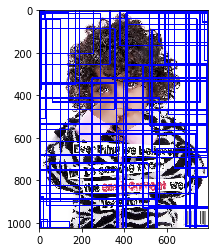

In [15]:
# float model inference
img_path = './open-images-dataset/000dbcc283d87f67.jpg'
model_path = os.path.join(OUTPUT_DIR, 'model_float.tflite')
input_data = get_float_img_data(img_path)
inference(input_data, model_path, img_path)

###### The detection_classes outputs are 0(s) ######

Generally, the display_name for label_id 0 is `background`.

###### What's the suitable threshold value for detection_scores? ######

According to the `tflite_graph.pbtxt`, the nms_score_threshold is 9.99999993923e-9.